<div style="background-color: #28a745 !important; color: white; min-height: 50px; padding: 10px; margin: auto;">
    <p style="text-align: right; font-style: italic">STMKGxHMGI Long Course</p>
    <h1>Sesi: Penentuan Episenter dengan Metode Lingkaran</h1>
</div>
<div style="background-color: whitesmoke; padding: 10px ">
    <ul>
        <li>Tujuan: Memperkenalkan cara penentuan episenter yang sederhana yaitu menggunakan metode lingkaran</li>
        <li>Keluaran: Peserta dapat memahami dasar secara sekilas kemudian mengimplementasikan dalam bentuk kode Python</li>
        <li>Sesi Latihan</li>
        <li>Waktu/Tempat: Sabtu, 25 September 2021/ Zoom</li>
    </ul>
</div>

## Latihan

Stasiun:
```
NET STA LAT LOT ELEV
II	ABPO	-19.02°	47.23°	1528 m  
P 2021-05-14 06:42:16  
S 2021-05-14 06:49:41  

IC	LSA	29.70°	91.13°	3660 m  
P 2021-05-14 06:39:15  
S 2021-05-14 06:44:14  

II	WRAB	-19.93°	134.36°	366 m  
P 2021-05-14 06:40:58  
S 2021-05-14 06:47:17  
```
Dari data di atas carilah perkiraan episenter menggunakan Metode Lingkaran!

Bandingkan dengan episenter sebenarnya dari IRIS:

```
0.1364° N	96.6442° E	2021-05-14 06:33:07 UTC	11.0 km	mww6.7	Off W Coast Of Northern Sumatra
```

### Hitung S-P dahulu untuk memperkirakan range penebakan jarak

In [4]:
from obspy import UTCDateTime

# DATA
ABPO_P = UTCDateTime("2021-05-14T06:42:16")
ABPO_S = UTCDateTime("2021-05-14 06:49:41")

LSA_P = UTCDateTime("2021-05-14T06:39:15")
LSA_S = UTCDateTime("2021-05-14T06:44:14")

WRAB_P = UTCDateTime("2021-05-14T06:40:58")
WRAB_S = UTCDateTime("2021-05-14T06:47:17")

# SP
ABPO_SP = ABPO_S-ABPO_P
LSA_SP = LSA_S-LSA_P
WRAB_SP = WRAB_S-WRAB_P

print("SP dalam menit")
print(ABPO_SP/60,LSA_SP/60,WRAB_SP/60)

SP dalam menit
7.416666666666667 4.983333333333333 6.316666666666666


There were 23 epicentral distances without an arrival


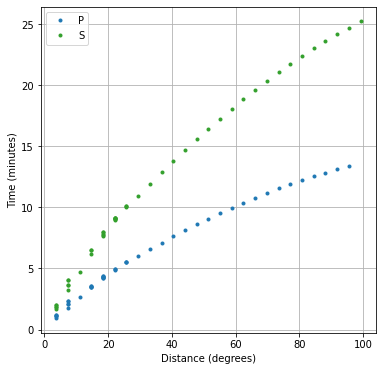

Text(0.5, 1.0, 'Kurva Waktu Tempuh P S untuk Kedalaman 10 km')

In [2]:
from obspy.taup import plot_travel_times
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
ax = plot_travel_times(source_depth=10, phase_list=["P", "S"],
                       ax=ax, fig=fig, verbose=True)
ax.set_title("Kurva Waktu Tempuh P S untuk Kedalaman 10 km")

Dengan mencocokkan SP dalam menit dengan kurva waktu tempuh di atas kita akan menggunakan tebakan jarak dari 25-55 dengan lompatan 1.

### Solusi tanpa titik episenter

Dengan mengubah sedikit kode yang sudah di rekap di atas, yang diubah adalah `DATA`, `KOODINAT dan NAMA`, `range tebakan` (`distance list`), `ax.set_extent`, dan episenter sebenarnya (line 97):

/home/anangsahroni/Environments/envgeneral/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/anangsahroni/Environments/envgeneral/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


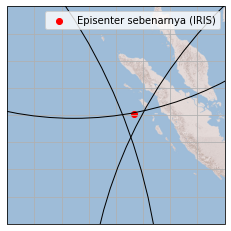

In [5]:
import math
import numpy as np
from scipy import stats
from obspy import UTCDateTime
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.io.img_tiles as cimgt
from obspy.taup import TauPyModel

# MODEL KECEPATAN
model = TauPyModel(model="iasp91")

# KEDALAMAN
depth=10 #km

# DATA
ABPO_P = UTCDateTime("2021-05-14T06:42:16")
ABPO_S = UTCDateTime("2021-05-14 06:49:41")

LSA_P = UTCDateTime("2021-05-14T06:39:15")
LSA_S = UTCDateTime("2021-05-14T06:44:14")

WRAB_P = UTCDateTime("2021-05-14T06:40:58")
WRAB_S = UTCDateTime("2021-05-14T06:47:17")


# KOORDINAT dan NAMA
ABPO_coor=(47.23,-19.02)
LSA_coor=(91.13,29.70)
WRAB_coor=(134.36,-19.93)
nama_stasiun = ["ABPO","LSA","WRAB"]


# SP
ABPO_SP = ABPO_S-ABPO_P
LSA_SP = LSA_S-LSA_P
WRAB_SP = WRAB_S-WRAB_P


# MENCARI JARAK
distance_list=np.arange(25,55,1) #Range tebakan
station_SP_list=[ABPO_SP,LSA_SP,WRAB_SP]

sta_distance_list=[]
for sta_SP in station_SP_list:
    initial_distance=distance_list[0]
    for dist in distance_list:
        arrivals = model.get_travel_times(source_depth_in_km=depth,
                                          distance_in_degree=dist,
                                          phase_list=["P","S"])
        P_arrival = arrivals[0].time

        # waktu tiba S harus sedikit hati-hari karena bisa ada banyak P dan S
        phase_names=np.array([arr.name for arr in arrivals]) # mengambil nama-nama fase
        S_indexes=np.where(phase_names=="S") #mengambil indeks lokasi S
        S_index=S_indexes[0][0] # mengambil indeks lokasi S pertama kali
        S_arrival = arrivals[S_index].time # waktu tiba S

        SP_taup = S_arrival-P_arrival

        if SP_taup<sta_SP:
            initial_distance = dist
            SP_error=abs(SP_taup-sta_SP) #menambah perhitungan SP_error

        else:
            SP_error_check = abs(SP_taup-sta_SP)
            if SP_error_check < SP_error: # jika SP_error sekarang < SP_error sebelumnya maka jarak tetap diupdate
                initial_distance = dist

    sta_distance_list.append(initial_distance)

# PLOT
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent((85,105,-10,10))

# Add custom background
terrain = cimgt.GoogleTiles(url='https://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/MapServer/tile/{z}/{y}/{x}.jpg',\
                           cache=True)
ax.add_image(terrain,8)

ax.set_xlabel("Longitude [deg]")
ax.set_ylabel("Latitude [deg]")

gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, zorder=1)

gl.xlabels_top = False
gl.ylabels_right = False

for sta,rad,nsta in zip([ABPO_coor, LSA_coor, WRAB_coor],\
               sta_distance_list,nama_stasiun):
    ax.scatter(sta[0],sta[1], zorder=100, marker="v", color="blue")
    draw_circle =plt.Circle(sta, rad, fill=False)
    ax.add_artist(draw_circle)
    ax.annotate(nsta, sta)

ax.scatter(96.6442,0.1364,color="red", label="Episenter sebenarnya (IRIS)")

ax.legend()
plt.savefig("../output/demo_epi_nopt.png",dpi=300)

### Solusi dengan titik hiposenter

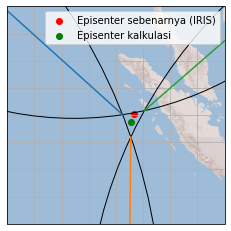

In [7]:
import math
import numpy as np
from scipy import stats
from obspy import UTCDateTime
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.io.img_tiles as cimgt
from obspy.taup import TauPyModel

# MODEL KECEPATAN
model = TauPyModel(model="iasp91")

# KEDALAMAN
depth=10 #km

# DATA
ABPO_P = UTCDateTime("2021-05-14T06:42:16")
ABPO_S = UTCDateTime("2021-05-14 06:49:41")

LSA_P = UTCDateTime("2021-05-14T06:39:15")
LSA_S = UTCDateTime("2021-05-14T06:44:14")

WRAB_P = UTCDateTime("2021-05-14T06:40:58")
WRAB_S = UTCDateTime("2021-05-14T06:47:17")


# KOORDINAT dan NAMA
ABPO_coor=(47.23,-19.02)
LSA_coor=(91.13,29.70)
WRAB_coor=(134.36,-19.93)
nama_stasiun = ["ABPO","LSA","WRAB"]


# SP
ABPO_SP = ABPO_S-ABPO_P
LSA_SP = LSA_S-LSA_P
WRAB_SP = WRAB_S-WRAB_P


# MENCARI JARAK
distance_list=np.arange(25,55,1) #Range tebakan
station_SP_list=[ABPO_SP,LSA_SP,WRAB_SP]

sta_distance_list=[]
for sta_SP in station_SP_list:
    initial_distance=distance_list[0]
    for dist in distance_list:
        arrivals = model.get_travel_times(source_depth_in_km=depth,
                                          distance_in_degree=dist,
                                          phase_list=["P","S"])
        P_arrival = arrivals[0].time

        # waktu tiba S harus sedikit hati-hari karena bisa ada banyak P dan S
        phase_names=np.array([arr.name for arr in arrivals]) # mengambil nama-nama fase
        S_indexes=np.where(phase_names=="S") #mengambil indeks lokasi S
        S_index=S_indexes[0][0] # mengambil indeks lokasi S pertama kali
        S_arrival = arrivals[S_index].time # waktu tiba S

        SP_taup = S_arrival-P_arrival

        if SP_taup<sta_SP:
            initial_distance = dist
            SP_error=abs(SP_taup-sta_SP) #menambah perhitungan SP_error

        else:
            SP_error_check = abs(SP_taup-sta_SP)
            if SP_error_check < SP_error: # jika SP_error sekarang < SP_error sebelumnya maka jarak tetap diupdate
                initial_distance = dist

    sta_distance_list.append(initial_distance)


    
# MENCARI TITIK
# fungsi titik potong 2 lingkaran
def circle_intersection(x0, y0, r0, x1, y1, r1):

    d = math.sqrt((x1 - x0) ** 2 + (y1 - y0) ** 2)

    if d > r0 + r1:             # non intersecting
        return None
    if d < abs(r0 - r1):        # one circle within other
        return None
    if d == 0 and r0 == r1:     # coincident circles
        return None

    a = (r0 ** 2 - r1 ** 2 + d ** 2) / (2 * d)
    h = math.sqrt(r0 ** 2 - a ** 2)
    x2 = x0 + a * (x1 - x0) / d
    y2 = y0 + a * (y1 - y0) / d
    x3 = x2 + h * (y1 - y0) / d
    y3 = y2 - h * (x1 - x0) / d

    x4 = x2 - h * (y1 - y0) / d
    y4 = y2 + h * (x1 - x0) / d

    return (x3, y3), (x4, y4)

# fungsi titik potong dua garis
def two_intersection(m1,c1,m2,c2):
    x=(c2-c1)/(m1-m2)
    y=m1*x+c1
    return x,y

# menghitung titik perpotongan lingkaran
TP_1, TP_2 = circle_intersection(ABPO_coor[0], ABPO_coor[1], sta_distance_list[0],\
                   LSA_coor[0], LSA_coor[1], sta_distance_list[1])

TC_1, TC_2 = circle_intersection(ABPO_coor[0], ABPO_coor[1], sta_distance_list[0],\
                   WRAB_coor[0], WRAB_coor[1], sta_distance_list[2])

PC_1, PC_2 = circle_intersection(LSA_coor[0], LSA_coor[1], sta_distance_list[1],\
                   WRAB_coor[0], WRAB_coor[1], sta_distance_list[2])
#ABPO LSA
TPx=[TP_1[0], TP_2[0]]
TPy=[TP_1[1], TP_2[1]]

#ABPO WRAB
TCx=[TC_1[0], TC_2[0]]
TCy=[TC_1[1], TC_2[1]]

# LSA_WRAB
PCx=[PC_1[0], PC_2[0]]
PCy=[PC_1[1], PC_2[1]]

# mencari slope dan itersep
result = stats.linregress(TPx, TPy)
mTP=result.slope
cTP=result.intercept

result = stats.linregress(TCx, TCy)
mTC=result.slope
cTC=result.intercept

result = stats.linregress(PCx, PCy)
mPC=result.slope
cPC=result.intercept

#mencari perpotongan garis chord
inter_TPPC=two_intersection(mTP, cTP, mPC, cPC)
inter_TPTC=two_intersection(mTP, cTP, mTC, cTC)
inter_PCTC=two_intersection(mPC, cPC, mTC, cTC)

#mererata perpotongan garis
x_av=(inter_TPPC[0]+inter_TPTC[0]+inter_PCTC[0])/3
y_av=(inter_TPPC[1]+inter_TPTC[1]+inter_PCTC[1])/3



# PLOT
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent((85,105,-10,10))

# Add custom background
terrain = cimgt.GoogleTiles(url='https://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/MapServer/tile/{z}/{y}/{x}.jpg',\
                           cache=True)
ax.add_image(terrain,7)

ax.set_xlabel("Longitude [deg]")
ax.set_ylabel("Latitude [deg]")

gl = ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, zorder=1)

gl.xlabels_top = False
gl.ylabels_right = False

for sta,rad,nsta in zip([ABPO_coor, LSA_coor, WRAB_coor],\
               sta_distance_list,nama_stasiun):
    ax.scatter(sta[0],sta[1], zorder=100, marker="v", color="blue")
    draw_circle =plt.Circle(sta, rad, fill=False)
    ax.add_artist(draw_circle)
    ax.annotate(nsta, sta)

ax.plot(TPx, TPy)
ax.plot(TCx, TCy)
ax.plot(PCx, PCy)

ax.scatter(96.6442,0.1364,color="red", label="Episenter sebenarnya (IRIS)")
ax.scatter(x_av,y_av,color="green", label="Episenter kalkulasi")

ax.legend()
plt.savefig("../output/demo_epi_pt.png",dpi=300)